# Speech model creation

In [3]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [20]:
Features = pd.read_csv("../../data/aud_em/features.csv")
# Convertir las columnas de la primera a la penúltima de tipo str a tipo float

In [22]:
# Convertir las columnas de la primera a la penúltima de tipo str a tipo float
Features = Features.drop(Features.columns[0], axis=1)

In [23]:
X = Features.iloc[: ,:-1].values
Y = Features['emotion'].values

In [24]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [25]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((8399, 1967), (8399, 6), (2800, 1967), (2800, 6))

In [13]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

ValueError: could not convert string to float: '-643.9976699848729+0j'

In [7]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape


((8826, 29, 1), (8826, 6), (2943, 29, 1), (2943, 6))

In [8]:
import tensorflow as tf
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
# config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2023-05-02 11:49:08.330251: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-02 11:49:08.330444: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-02 11:49:08.351315: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-02 11:49:08.351581: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-02 11:49:08.351796: I tensorflow/compiler/xla/stream_executo

In [9]:
model = Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(29, 1)))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=6, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


2023-05-02 11:49:08.428432: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 11:49:08.591764: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-02 11:49:08.591958: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-02 11:49:08.592127: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 29, 256)           1536      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 15, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 15, 256)           327936    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 256)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 8, 128)            163968    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 4, 128)            0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 128)            0

In [10]:
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping

cp = ModelCheckpoint('saved/best_weights.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history=model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=100, callbacks=[early_stopping, cp])

Epoch 1/100


2023-05-02 11:49:10.780679: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-05-02 11:49:13.109075: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


276/276 [==============================] - 5s 5ms/step - loss: 1.5646 - accuracy: 0.3447 - val_loss: 1.4118 - val_accuracy: 0.3833
Epoch 2/100
276/276 [==============================] - 1s 3ms/step - loss: 1.4173 - accuracy: 0.3912 - val_loss: 1.3568 - val_accuracy: 0.4224
Epoch 3/100
276/276 [==============================] - 1s 3ms/step - loss: 1.3526 - accuracy: 0.4267 - val_loss: 1.3131 - val_accuracy: 0.4489
Epoch 4/100
276/276 [==============================] - 1s 3ms/step - loss: 1.3258 - accuracy: 0.4381 - val_loss: 1.2845 - val_accuracy: 0.4570
Epoch 5/100
276/276 [==============================] - 1s 3ms/step - loss: 1.2987 - accuracy: 0.4546 - val_loss: 1.3079 - val_accuracy: 0.4424
Epoch 6/100
276/276 [==============================] - 1s 3ms/step - loss: 1.2828 - accuracy: 0.4584 - val_loss: 1.2470 - val_accuracy: 0.4811
Epoch 7/100
276/276 [==============================] - 1s 3ms/step - loss: 1.2565 - accuracy: 0.4685 - val_loss: 1.2696 - val_accuracy: 0.4788
Epoch 8/100

92/92 [==============================] - 0s 1ms/step - loss: 1.2145 - accuracy: 0.5042
Accuracy of our model on test data :  50.424736738204956 %


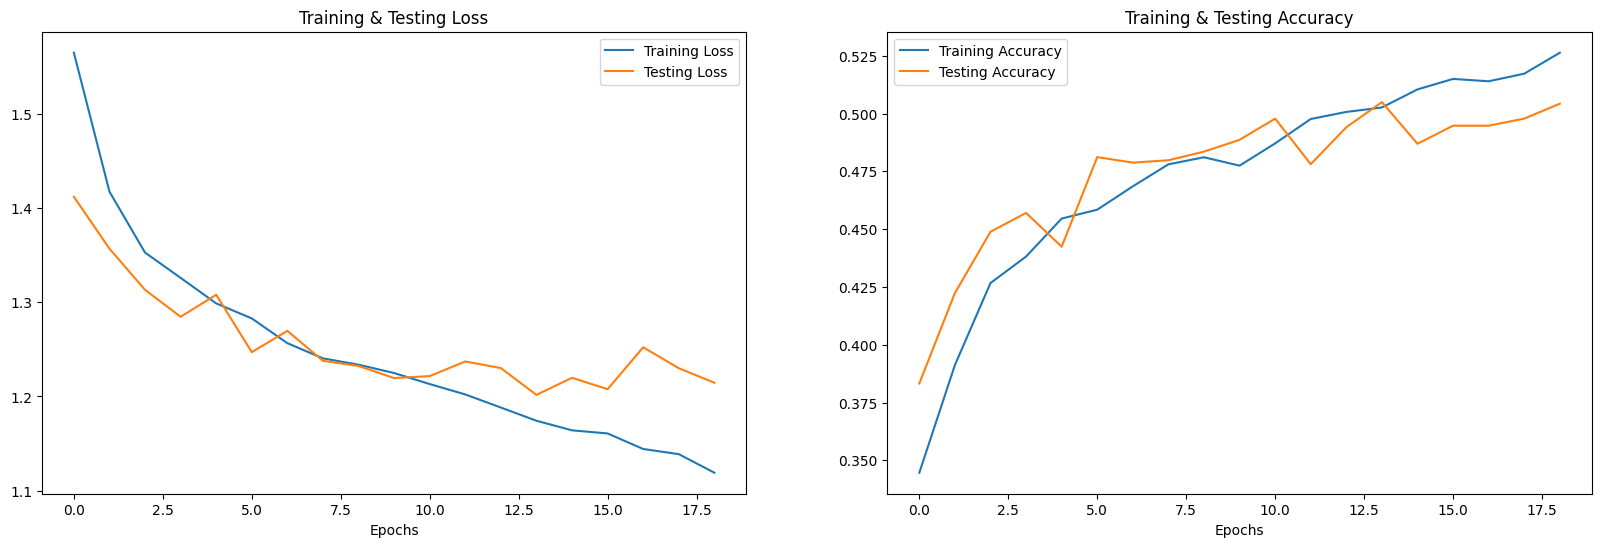

In [11]:
from matplotlib import pyplot as plt

num_epochs = len(history.epoch)

print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(num_epochs)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [12]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [13]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,anger,fear
1,anger,neutral
2,anger,neutral
3,neutral,anger
4,neutral,sadness
5,surprise,surprise
6,neutral,neutral
7,neutral,joy
8,anger,neutral
9,anger,anger


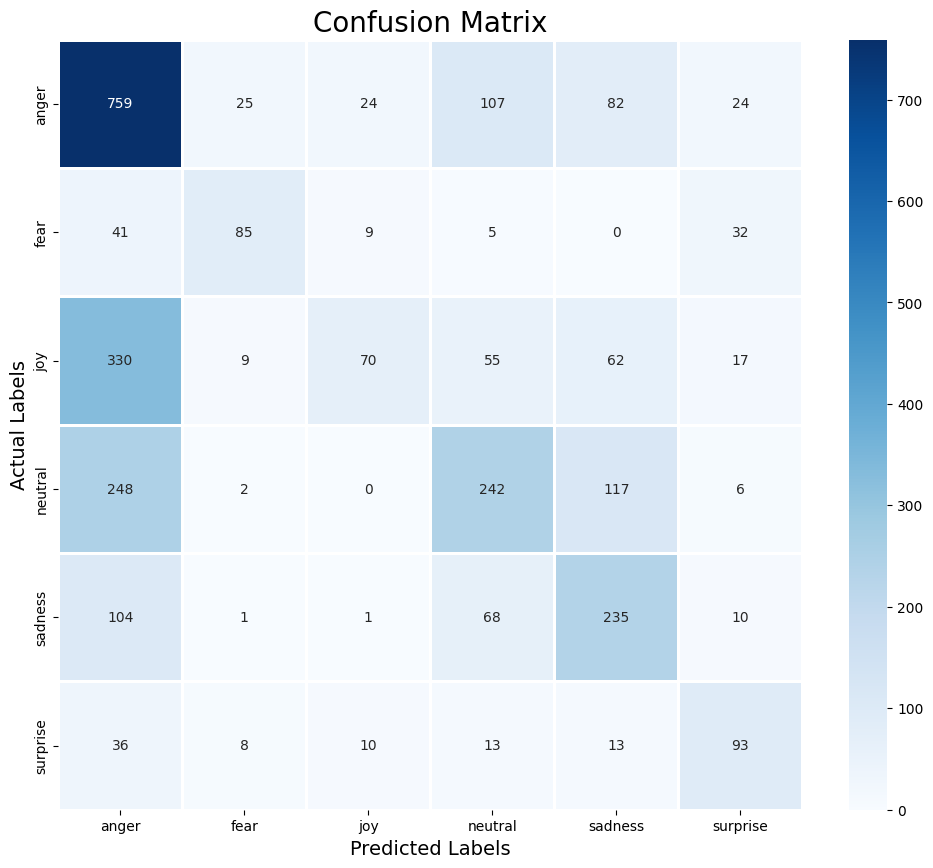

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [15]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.50      0.74      0.60      1021
        fear       0.65      0.49      0.56       172
         joy       0.61      0.13      0.21       543
     neutral       0.49      0.39      0.44       615
     sadness       0.46      0.56      0.51       419
    surprise       0.51      0.54      0.52       173

    accuracy                           0.50      2943
   macro avg       0.54      0.48      0.47      2943
weighted avg       0.52      0.50      0.47      2943

